In [ ]:
import warnings
from collections import Counter
from tqdm import tqdm
import graphviz
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import pydotplus
import seaborn as sns
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, RandomOverSampler
from plotly import express as px
from sklearn import datasets, metrics, neighbors, preprocessing, tree
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             r2_score, recall_score, confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
from pandas.io.formats.style import plt
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Punto 1

In [ ]:
parent_General = r'/content/drive/MyDrive/Uniquindío/Maestría en Ingeniería/Cohorte II'

parent = parent_General
archivo = r'/Dataset_final_limpio.xlsx'
df = pd.read_excel(''.join([parent, archivo]))

In [ ]:
def oversample(X_train, y_train):
      os =  RandomOverSampler()
      X_train_res, y_train_res = os.fit_resample(X_train, y_train)
      
      print ("Antes de  resampling {}".format(Counter(y_train)))
      print ("Despues del  resampling {}".format(Counter(y_train_res)))
      
      return X_train_res, y_train_res

def obtener_performance_classification(y_true, y_pred, pos_label):
    
    accuracy = accuracy_score(y_true, y_pred, normalize=True)
    prec = precision_score(y_true, y_pred, pos_label=pos_label)
    recall = recall_score(y_true, y_pred, pos_label=pos_label)
    f1_score1 = f1_score(y_true, y_pred, average='macro', pos_label=pos_label) 
    
    return {'accuracy': accuracy, 
            'precision': prec,
            'recall':recall, 
            'f1_score':f1_score1}

class ModelSelection:
  def __init__(self, model_settings):
    keys = {'model', 'gs_parameters'}
    all_keys_included = True
    for model_setting in model_settings:
      all_keys_included = all_keys_included and keys.issubset(model_setting.keys())
      if not all_keys_included:
        break
    if not all_keys_included:
      raise KeyError(f'Cada elemento de model_settings debe tener al menos las siguientes llaves: {keys}')
    
    self.model_settings = model_settings

  @staticmethod
  def __one_grid_search__(model_setting: dict, X_train, y_train):
    parameters = model_setting['gs_parameters']
    model = model_setting['model']
    grid_search = GridSearchCV(model, parameters, cv=5, return_train_score=True)
    grid_search.fit(X_train, y_train)
    d = {'best_params_':grid_search.best_params_, 'model_fitted':grid_search.best_estimator_}
    d.update(model_setting)
    return d

  @staticmethod
  def __one_obtener_performance_classification__(model_setting, y_test, y_pred, pos_label):
    perf = {'performance':obtener_performance_classification(y_test, y_pred, pos_label=pos_label)}
    perf.update(model_setting)
    return perf

  def get_model_by_id(self, _id):
    filtered_list = list(filter(lambda model_setting: model_setting['_id']==_id, self.model_settings))
    if len(filtered_list) == 0:
      raise KeyError(f'_id: {_id} no encontrado.')
    elif len(filtered_list) > 1:
      raise Exception(f'_id: {_id} encontrado más de una vez')
    return filtered_list[0]['model_fitted']

  def __grid_search__(self, X_train, y_train):
    self.model_settings = [
        ModelSelection.__one_grid_search__(model_setting, X_train, y_train) 
        for model_setting in tqdm(self.model_settings,desc='Grid search')]

  def __obtener_performance_classification__(self, X_test, y_test, pos_label):
    model_pred = zip(
        self.model_settings, 
        map(lambda x: x['model_fitted'].predict(X_test), self.model_settings)
        )
    self.model_settings = [
        ModelSelection.__one_obtener_performance_classification__(model_setting, y_test, y_pred, pos_label)
        for model_setting, y_pred in tqdm(model_pred, desc='Calculando metricas de clasificación')]

  def fit(self, X_train, X_test, y_train, y_test, metric, pos_label):
    metrics = {'accuracy', 'precision', 'recall', 'f1_score'}
    if not metric in metrics:
      raise AttributeError(f'metric debe ser alguno de {metrics}')
    self.__grid_search__(X_train, y_train)
    self.__obtener_performance_classification__(X_test, y_test, pos_label=pos_label)
    self.model_settings = list(sorted(self.model_settings, key=lambda model_setting: model_setting['performance'][metric], reverse=True))
    self.best_model_setting = self.model_settings[0]
    print()
    print(f'Competencia finalizada, modelo ganador: {self.best_model_setting}')

  def predict(self, X):
    best_model = self.best_model_setting['model_fitted']
    return best_model.predict(X)

  def get_ranking(self):
    def select_keys(d: dict, keys: list):
      return {key: d[key] for key in keys}

    modelos = list(
        sorted(
            [select_keys(setting, ['_id', 'model_fitted', 'best_params_', 'performance']) for setting in ms.model_settings],
            key = lambda setting: setting['performance']['f1_score'], reverse=True
            ))
    return modelos

class Graficar:
  def __init__(self, colores=None):
    if colores is None:
      self.colores = {
          'femenino':'#ff69b4',
          'masculino':'#7858da',
          'correcto':'#1CDB59',
          'incorrecto':'#fa1e1e',
          'c1':'#79216d',
          'c2':'#ca1e3f',
          'c3':'#b26116',
          'c4':'#a0933a',
          'c5':'#a3f789'
      }
    else:
      self.colores = colores

    self.color_discrete_sequence=[self.colores[c] for c in ['c1','c2','c3','c4','c5']]
    self.color_continuous_scale = ["#fff", self.colores['c1']]

  def heatmap(self, df, **kwargs):
    return px.imshow(df, color_continuous_scale=self.color_continuous_scale,**kwargs)

  def box(self, df, x=None, y=None, title=None, notched=True, **kwargs):
    if title is None:
      title=f'Boxplot {x} vs {y}' if x is not None else f'Boxplot {y}'
    return px.box(df, x=x, y=y, title=title, notched=notched,
                  color_discrete_sequence=self.color_discrete_sequence, **kwargs)

  def histogram(self, df=None, x=None, text_auto=True,**kwargs):
    return px.histogram(df, x=x, text_auto=text_auto, 
                        color_discrete_sequence=self.color_discrete_sequence, **kwargs)

  def scatter(self, df, correct_incorrect_map=None,**kwargs):
    if correct_incorrect_map is None:
      return px.scatter(data_frame=df, 
                        color_discrete_sequence=self.color_discrete_sequence, **kwargs)
    else:
      color_discrete_map = {
          correct_incorrect_map['correcto']:self.colores['correcto'],
          correct_incorrect_map['incorrecto']:self.colores['incorrecto']
                            }
      return px.scatter(data_frame=df, color_discrete_map=color_discrete_map, **kwargs)

  def pyramid(self, df, x, bins, cat_col, cat1, cat1name, cat1color, cat2, cat2name, cat2color):
    min = df[x].min()
    max = df[x].max()
    limites = [round(x) for x in np.linspace(min, max, bins)]
    labels = [f'[{lim_min}-{lim_max})' 
              for (lim_min, lim_max) in zip(limites[0:bins-1],limites[1:bins])]

    bins_1 = pd.cut(df.loc[df[cat_col] == cat1][x], bins=limites, labels=labels, include_lowest=True)
    bins_2 = pd.cut(df.loc[df[cat_col] == cat2][x], bins=limites, labels=labels, include_lowest=True)

    bins_1.name = cat1name
    bins_2.name = cat2name

    grouped_1 = bins_1.groupby(bins_1).count()
    grouped_2 = bins_2.groupby(bins_2).count()

    data = pd.DataFrame([grouped_1, grouped_2]).transpose()

    y = data.index
    x_1 = data[cat1name]
    x_2 = data[cat2name] * (-1)
    meta = data[cat2name]

    fig = go.Figure()
    bar1 = go.Bar(y=y, x=x_1, name=cat1name, orientation = 'h', 
                  texttemplate='%{x}',marker_color=cat1color)
    bar2 = go.Bar(y=y, x=x_2, name=cat2name, orientation = 'h', 
                  texttemplate='%{meta}',marker_color=cat2color,meta=meta)
    fig.add_trace(bar1)
    fig.add_trace(bar2)
    fig.update_layout(title='Pirámide poblacional', barmode='relative',bargap=0.0, 
                      bargroupgap = 0 )
    return fig

In [ ]:
graficar = Graficar()
#X_names=['SRL','days_act','TaskStrategies', 'StrategicPlanning', 'explore', 'GoalSetting']
X_names = [ 'SRL', 'days_act', 'num_ses', 'TaskStrategies', 'StrategicPlanning', 'completer']
y_name='Gano'
test_size = 0.3
random_state = 1

## Punto 2

Analice cómo es el comportamiento de la clase (agregue gráficos). Si observa desbalance realice acciones correctivas.

In [ ]:
graficar.histogram(df, y_name).show()

Se observa un desbalanceo de clases, debido a la baja cantidad de datos se realizará un sobremuestreo de la clase NO.

In [ ]:
# Obteniendo X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(df[X_names], df[y_name], test_size=test_size, random_state=random_state)

X_train, y_train = oversample(X_train=X_train, y_train=y_train)

Antes de  resampling Counter({'SI': 185, 'NO': 160})
Despues del  resampling Counter({'NO': 185, 'SI': 185})


In [ ]:
graficar.histogram(y_train)

In [ ]:
df

,Unnamed: 0,GoalSetting,StrategicPlanning,SelfEvaluation,TaskStrategies,Elaboration,HelpSeeking,SRL,only lecture,Atry to lecture,...,isfemale,emp_student,emp_job,completer,days_act,num_events,num_ses,grade,cluster,Gano
0,0,2.50,1.50,1.666667,0.833333,2.000000,1.50,1.666667,5,0,...,0,0,1,0,13,2,16,6.000000,0,NO
1,1,2.75,3.00,2.000000,1.000000,3.000000,1.50,2.208333,0,0,...,0,1,0,0,1,1,1,0.000000,0,NO
2,2,2.25,1.75,1.333333,1.000000,2.000000,0.50,1.472222,3,0,...,0,0,1,0,1,1,1,0.000000,0,NO
3,3,2.50,2.75,1.333333,1.166667,2.333333,2.75,2.138889,2,0,...,0,1,0,0,1,5,1,0.000000,0,NO
4,4,0.50,2.00,2.000000,1.166667,2.333333,1.25,1.541667,4,0,...,0,0,1,0,2,13,2,0.000000,0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,489,4.00,3.00,4.000000,3.500000,3.666667,2.75,3.486111,12,170,...,0,0,1,0,12,305,19,75.000000,1,SI
490,490,3.75,3.75,3.666667,3.500000,3.666667,3.25,3.597222,28,170,...,0,0,1,0,14,246,35,81.142855,1,SI
491,491,4.00,4.00,4.000000,4.000000,4.000000,3.75,3.958333,49,170,...,0,0,1,0,13,269,36,87.685716,1,SI
492,492,2.00,2.25,2.000000,2.500000,2.333333,1.00,2.013889,24,180,...,0,1,0,1,21,407,36,89.952379,1,SI


In [ ]:
#parameters = {'max_depth': [1, 2, 4, 5, 7, 9, 10,12,24,48,96], 'criterion': ["gini", "entropy", "log_loss"]}

#grid_search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, return_train_score=True)
#grid_search.fit(X_train, y_train)

#grid_search.best_params_

model_settings = [
     {
        '_id': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(),
        'gs_parameters': {'max_depth':[1, 2, 4, 5, 7, 9, 10, 12, 24, 48,96], 'criterion': ['gini', 'entropy', 'log_loss']}
     },
     {
        '_id': 'KNeighborsClassifier',
        'model': KNeighborsClassifier(),
        'gs_parameters': {'n_neighbors': [1,2,3,4,5,6,7,8,9,10],'leaf_size':[1,2,4,8,16,32], 'p':[1,2]}  
     },
     {
         '_id': 'RadiusNeighborsClassifier',
         'model': RadiusNeighborsClassifier(),
         'gs_parameters': {'weights': ['uniform','distance'], 'leaf_size':[1,2,4,8,16,32], 'p':[1,2], 'radius':[1,1.1,1.2,1.4,1.8,2,4],'outlier_label':['most_frequent']}
     }
]

ms = ModelSelection(model_settings)
ms.fit(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, metric='f1_score', pos_label='SI')

Grid search: 100%|██████████| 3/3 [00:26<00:00,  8.70s/it]
Calculando metricas de clasificación: 3it [00:00, 83.34it/s]


Competencia finalizada, modelo ganador: {'performance': {'accuracy': 0.9798657718120806, 'precision': 1.0, 'recall': 0.9662921348314607, 'f1_score': 0.9792334494773518}, 'best_params_': {'criterion': 'entropy', 'max_depth': 4}, 'model_fitted': DecisionTreeClassifier(criterion='entropy', max_depth=4), '_id': 'DecisionTreeClassifier', 'model': DecisionTreeClassifier(), 'gs_parameters': {'max_depth': [1, 2, 4, 5, 7, 9, 10, 12, 24, 48, 96], 'criterion': ['gini', 'entropy', 'log_loss']}}


In [ ]:
y_pred = ms.predict(X_test)

print(obtener_performance_classification(y_test, y_pred,pos_label='SI'))

{'accuracy': 0.9798657718120806, 'precision': 1.0, 'recall': 0.9662921348314607, 'f1_score': 0.9792334494773518}


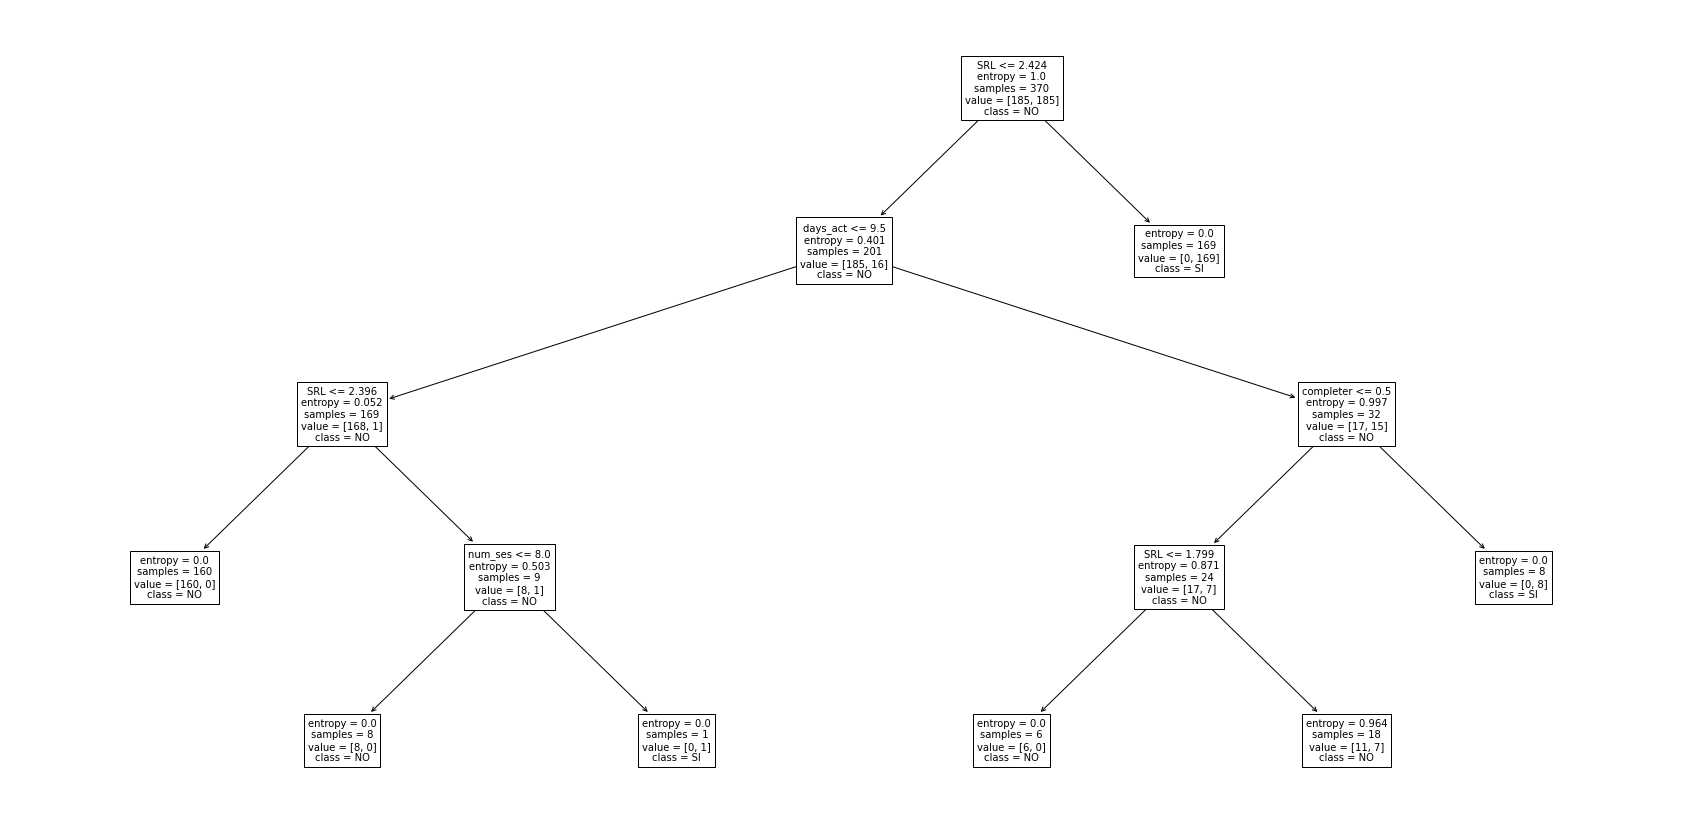

In [ ]:
decision_tree_model = ms.get_model_by_id('DecisionTreeClassifier')
plt.figure(figsize=(30,15))
lista = plot_tree(decision_tree_model,feature_names=X_train.columns,class_names=list(sorted(['SI','NO'])), fontsize=10)
plt.show()

In [ ]:
df[y_name]

0      NO
1      NO
2      NO
3      NO
4      NO
       ..
489    SI
490    SI
491    SI
492    SI
493    SI
Name: Gano, Length: 494, dtype: object

In [ ]:
print (df.dtypes)
#split dataset in features and target variable

# otra forma de hacer lo mismo
# X = df.drop('sobreviviente', axis=1)
#Y = df['sobreviviente']

# Create Decision Tree classifer object
#verificar si usa Gini o usa entropia
clf = DecisionTreeClassifier(criterion='entropy')
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

Unnamed: 0                int64
GoalSetting             float64
StrategicPlanning       float64
SelfEvaluation          float64
TaskStrategies          float64
Elaboration             float64
HelpSeeking             float64
SRL                     float64
only lecture              int64
Atry to lecture           int64
explore                   int64
only asessment            int64
Lcomplete to Atry         int64
lecture to Acomplete      int64
hrs                       int64
prior_exp                 int64
crs_str                   int64
crs_fin                   int64
int_topic                 int64
int_assess                int64
edu                       int64
age                     float64
isfemale                  int64
emp_student               int64
emp_job                   int64
completer                 int64
days_act                  int64
num_events                int64
num_ses                   int64
grade                   float64
cluster                   int64
Gano    

In [ ]:
clf 

DecisionTreeClassifier(criterion='entropy')

In [ ]:
#Predict the response for test dataset
print ("Se hacen las predicciones")
y_pred = clf.predict(X_test)
y_pred

Se hacen las predicciones


array(['SI', 'NO', 'NO', 'NO', 'NO', 'NO', 'SI', 'NO', 'NO', 'SI', 'SI',
       'NO', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'NO', 'NO', 'SI', 'NO',
       'NO', 'SI', 'NO', 'NO', 'SI', 'SI', 'NO', 'SI', 'NO', 'NO', 'SI',
       'NO', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'NO', 'SI', 'NO',
       'SI', 'NO', 'NO', 'SI', 'NO', 'SI', 'NO', 'SI', 'SI', 'SI', 'NO',
       'NO', 'SI', 'SI', 'SI', 'SI', 'SI', 'NO', 'SI', 'SI', 'SI', 'SI',
       'SI', 'NO', 'SI', 'NO', 'NO', 'NO', 'SI', 'SI', 'SI', 'NO', 'SI',
       'SI', 'SI', 'NO', 'NO', 'SI', 'SI', 'SI', 'NO', 'SI', 'SI', 'SI',
       'SI', 'NO', 'SI', 'NO', 'SI', 'SI', 'SI', 'NO', 'SI', 'SI', 'SI',
       'NO', 'SI', 'NO', 'SI', 'SI', 'SI', 'NO', 'SI', 'NO', 'SI', 'NO',
       'SI', 'SI', 'SI', 'NO', 'NO', 'SI', 'SI', 'NO', 'NO', 'SI', 'SI',
       'SI', 'SI', 'SI', 'NO', 'NO', 'NO', 'NO', 'NO', 'SI', 'NO', 'SI',
       'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI',
       'NO', 'NO', 'NO', 'NO', 'NO', 'SI'], dtype=o

In [ ]:
y2_pred = clf.predict(X_test)

print("La prediccion "+str(y2_pred))

La prediccion ['SI' 'NO' 'NO' 'NO' 'NO' 'NO' 'SI' 'NO' 'NO' 'SI' 'SI' 'NO' 'SI' 'SI'
 'SI' 'SI' 'SI' 'SI' 'NO' 'NO' 'SI' 'NO' 'NO' 'SI' 'NO' 'NO' 'SI' 'SI'
 'NO' 'SI' 'NO' 'NO' 'SI' 'NO' 'SI' 'SI' 'SI' 'SI' 'SI' 'SI' 'SI' 'NO'
 'SI' 'NO' 'SI' 'NO' 'NO' 'SI' 'NO' 'SI' 'NO' 'SI' 'SI' 'SI' 'NO' 'NO'
 'SI' 'SI' 'SI' 'SI' 'SI' 'NO' 'SI' 'SI' 'SI' 'SI' 'SI' 'NO' 'SI' 'NO'
 'NO' 'NO' 'SI' 'SI' 'SI' 'NO' 'SI' 'SI' 'SI' 'NO' 'NO' 'SI' 'SI' 'SI'
 'NO' 'SI' 'SI' 'SI' 'SI' 'NO' 'SI' 'NO' 'SI' 'SI' 'SI' 'NO' 'SI' 'SI'
 'SI' 'NO' 'SI' 'NO' 'SI' 'SI' 'SI' 'NO' 'SI' 'NO' 'SI' 'NO' 'SI' 'SI'
 'SI' 'NO' 'NO' 'SI' 'SI' 'NO' 'NO' 'SI' 'SI' 'SI' 'SI' 'SI' 'NO' 'NO'
 'NO' 'NO' 'NO' 'SI' 'NO' 'SI' 'SI' 'SI' 'SI' 'SI' 'SI' 'SI' 'SI' 'SI'
 'SI' 'SI' 'SI' 'NO' 'NO' 'NO' 'NO' 'NO' 'SI']


In [ ]:
decision_tree_model

DecisionTreeClassifier(criterion='entropy', max_depth=4)

# Punto 4
Validación cruzada

In [ ]:
# se efectúa validación cruzada
from sklearn import model_selection
kFold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'
puntaje= (model_selection.cross_val_score(clf, X_train, y_train,  scoring = scoring, cv = kFold))
print (f"( {puntaje.mean()}, {puntaje.std()}")

( 0.9594594594594594, 0.04399681242189108


# Punto 5
Matriz de confusión

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(f'Matriz de confusión:\n{cm}')
print(f'TN: {cm[0,0]}')
print(f'FN: {cm[1,0]}')
print(f'TP: {cm[1,1]}')
print(f'FP: {cm[0,1]}')

Matriz de confusión:
[[56  4]
 [ 2 87]]
TN: 56
FN: 2
TP: 87
FP: 4


De acuerdo con la documentación:

cm[0,0]: True negatives

cm[1,0]: False negaives

cm[1,1]: True positives

cm[0,1]: False positives

##6 Conclusion del arbol de desicion 

1. Se puede concluir que la variable SRL es el nodo principal del arbol, dado es el que tiene mayor correlacion con la variable predictoria:

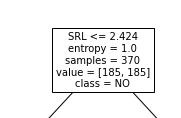

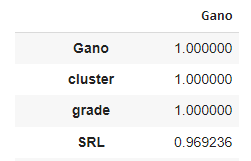

2. Se puede observar que de acuerdo con la primera conslusión del PEC1:

  Aquellos estudiantes que sacaron un puntaje SRL <= 2.42 tienen mayor riesgo de perder el exámen, tal como se observa en la siguiente imagen esto concuerda con los resultados obtenidos por el árbol de decisión

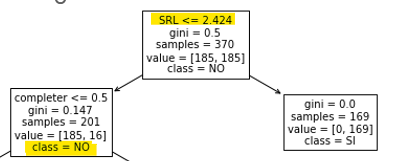

  3. Los estudiaste que tuvieron menos de 9.5 dias activos en el curso tienen una probabilidad alta de perder la materia:

  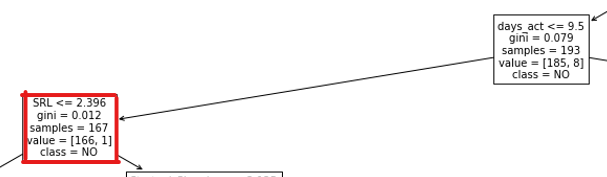

4. Se observa que la importancia de las variables obtenidas en el PEC1:

'SRL', 'num_events', 'Atry to lecture', 'days_act', 'num_ses', 'TaskStrategies', 'StrategicPlanning', 'completer'

No concuerda con la importancia de las variables obtenidas con el arbol de decisión, aunque algunas están presentes en ambas, esto se debe a que se descartaron algunos atributos para el entrenamiento debido a una correlación demasiado alta que provocaba un arbol con una sola rama.

5. Las variables del modelo tienen una correlacion tan alta con la variable objetivo que el modelo puede predecir si un estudiante gana o no la meterias desde el nodo principal:

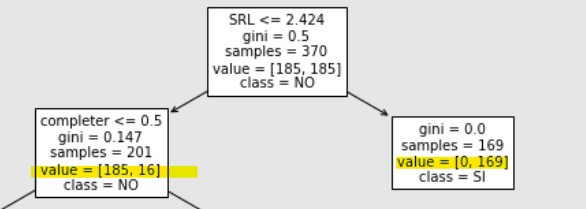


6. De acuerdo con el modelo conseguido, aquellas personas con un puntaje SRL <= 2.396, completer <= 0.5 y days_act <= 9.5, no ganarán el examen.

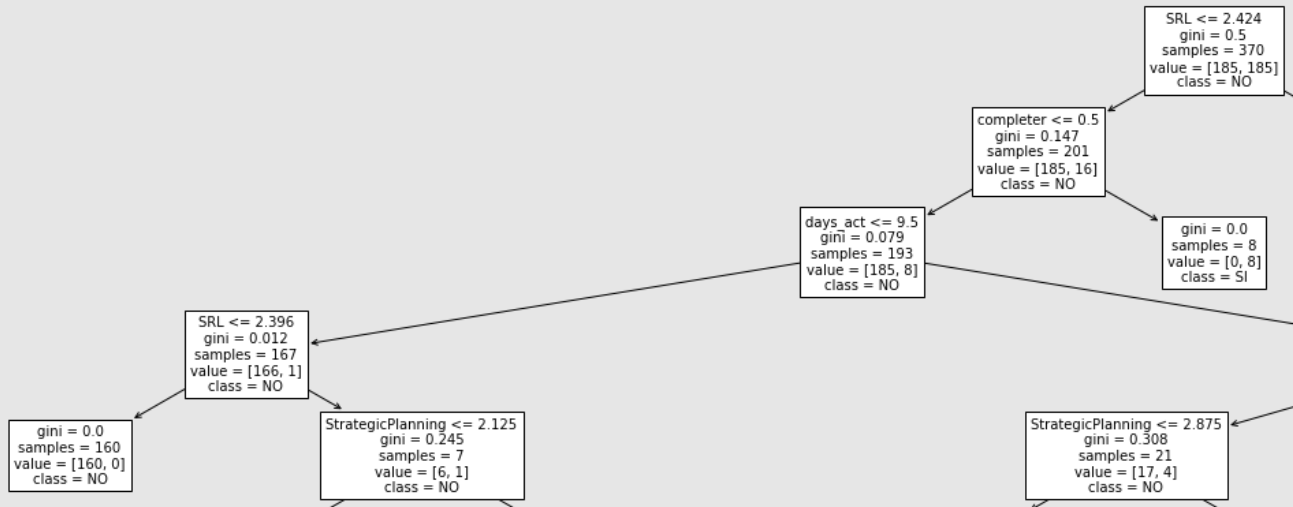




7. De acuerdo con la siguiente imagen:

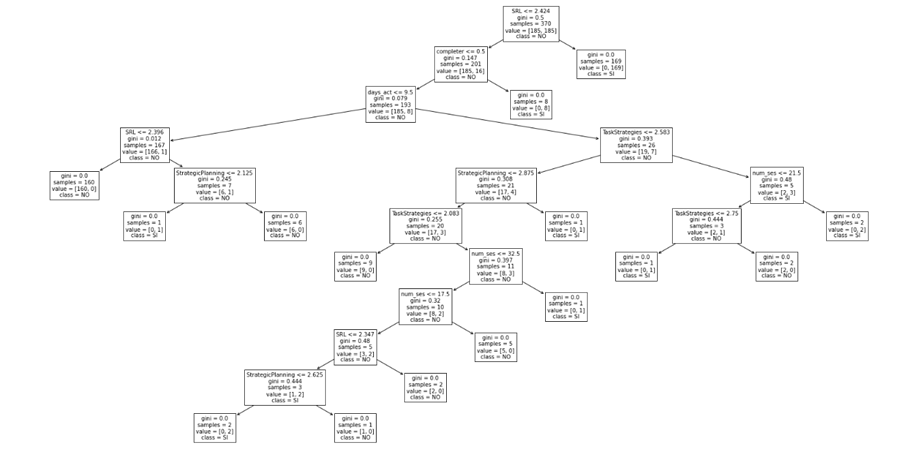

Las variables que mas le aportan a la predicción son: SRL, completer, days_act, TaskStrategies, StrategicPlanning y num_ses.

##8. Ahora use un método para seleccionar características y nuevamente aplique DecisionTree. Repita los pasos 3 a 5.



In [ ]:
from sklearn.feature_selection import SelectKBest
from numpy import array 
X = df.drop(['Gano','grade','cluster','Unnamed: 0'], axis=1)
y = df['Gano']

#este es un metodo de seleccion de caracteristicas
#le da puntaje a cada caracteristica y borra todas las demas
#excepto las que tienen puntaje mas alto

#https://aprendeia.com/metodos-de-seleccion-de-caracteristicas-machine-learning/
# tambien se puede elegir SelectKBest(score_func=chi2, k=5)
# https://jdvelasq.github.io/courses/notebooks/sklearn_supervised_01_feature_selection/1-06_SelectKBest.html
# se basa en un test de estadistica univariada,por ejemplo chi2,  Pearson-correlation 
best=SelectKBest(k=5)

features = array(X.columns)
features



array(['GoalSetting', 'StrategicPlanning', 'SelfEvaluation',
       'TaskStrategies', 'Elaboration', 'HelpSeeking', 'SRL',
       'only lecture', 'Atry to lecture', 'explore', 'only asessment',
       'Lcomplete to Atry', 'lecture to Acomplete', 'hrs', 'prior_exp',
       'crs_str', 'crs_fin', 'int_topic', 'int_assess', 'edu', 'age',
       'isfemale', 'emp_student', 'emp_job', 'completer', 'days_act',
       'num_events', 'num_ses'], dtype=object)

In [ ]:
X_new = best.fit_transform(X, y)

filter_1 = best.get_support()
print(features[filter_1])

['SRL' 'Atry to lecture' 'days_act' 'num_events' 'num_ses']


In [ ]:
X_new

array([[  1.66666667,   0.        ,  13.        ,   2.        ,
         16.        ],
       [  2.20833333,   0.        ,   1.        ,   1.        ,
          1.        ],
       [  1.47222222,   0.        ,   1.        ,   1.        ,
          1.        ],
       ...,
       [  3.95833333, 170.        ,  13.        , 269.        ,
         36.        ],
       [  2.01388889, 180.        ,  21.        , 407.        ,
         36.        ],
       [  3.38888889, 190.        ,  16.        , 323.        ,
         24.        ]])

In [ ]:
best.scores_

array([2.85877910e+02, 3.75270651e+02, 3.12097238e+02, 4.31990040e+02,
       3.60197682e+02, 9.19870043e+01, 6.68386505e+02, 3.64972764e+02,
       2.95554347e+03, 2.14556602e+02, 1.57881290e+02, 3.98700125e+01,
       2.30331243e+01, 3.49499868e+01, 1.91241313e+01, 1.12544606e+01,
       1.16419553e+01, 1.92734084e+01, 1.68765349e+01, 6.07274261e+00,
       2.88817424e+01, 2.46152499e+00, 1.50446032e+01, 5.67572656e+00,
       3.02942440e+02, 5.70235473e+02, 1.51999382e+03, 4.38166207e+02])

In [ ]:

#X_names=['SRL','days_act','TaskStrategies', 'StrategicPlanning', 'explore', 'GoalSetting']
X_names = features[filter_1]
y_name='Gano'
test_size = 0.3
random_state = 1


In [ ]:
# Obteniendo X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(df[X_names], df[y_name], test_size=test_size, random_state=random_state)

X_train, y_train = oversample(X_train=X_train, y_train=y_train)

Antes de  resampling Counter({'SI': 185, 'NO': 160})
Despues del  resampling Counter({'NO': 185, 'SI': 185})


In [ ]:
#parameters = {'max_depth': [1, 2, 4, 5, 7, 9, 10,12,24,48,96], 'criterion': ["gini", "entropy", "log_loss"]}

#grid_search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, return_train_score=True)
#grid_search.fit(X_train, y_train)

#grid_search.best_params_

model_settings = [
     {
        '_id': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(),
        'gs_parameters': {'max_depth':[1, 2, 4, 5, 7, 9, 10, 12, 24, 48,96], 'criterion': ['gini', 'entropy', 'log_loss']}
     },
     {
        '_id': 'KNeighborsClassifier',
        'model': KNeighborsClassifier(),
        'gs_parameters': {'n_neighbors': [1,2,3,4,5,6,7,8,9,10],'leaf_size':[1,2,4,8,16,32], 'p':[1,2]}  
     },
     {
         '_id': 'RadiusNeighborsClassifier',
         'model': RadiusNeighborsClassifier(),
         'gs_parameters': {'weights': ['uniform','distance'], 'leaf_size':[1,2,4,8,16,32], 'p':[1,2], 'radius':[1,1.1,1.2,1.4,1.8,2,4],'outlier_label':['most_frequent']}
     }
]

ms = ModelSelection(model_settings)
ms.fit(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, metric='f1_score', pos_label='SI')

Grid search: 100%|██████████| 3/3 [00:23<00:00,  7.97s/it]
Calculando metricas de clasificación: 3it [00:00, 82.93it/s]


Competencia finalizada, modelo ganador: {'performance': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}, 'best_params_': {'criterion': 'gini', 'max_depth': 2}, 'model_fitted': DecisionTreeClassifier(max_depth=2), '_id': 'DecisionTreeClassifier', 'model': DecisionTreeClassifier(), 'gs_parameters': {'max_depth': [1, 2, 4, 5, 7, 9, 10, 12, 24, 48, 96], 'criterion': ['gini', 'entropy', 'log_loss']}}


In [ ]:
y_pred = ms.predict(X_test)

print(obtener_performance_classification(y_test, y_pred,pos_label='SI'))

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


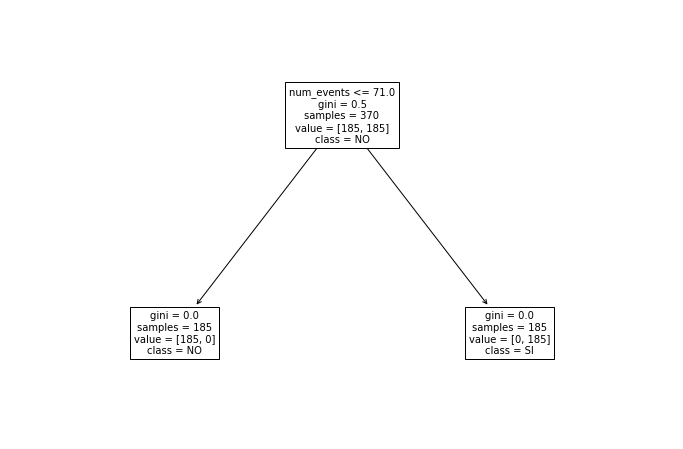

In [ ]:
decision_tree_model = ms.get_model_by_id('DecisionTreeClassifier')
plt.figure(figsize=(12,8))
lista = plot_tree(decision_tree_model,feature_names=X_train.columns,class_names=list(sorted(['SI','NO'])), fontsize=10)
plt.show()

# Punto 9 Repita el proceso  para Random Forest. Además use  feature_importances_ del algoritmo de bosque aleatorio en scikit-learn para mostrar las variables más importantes


In [ ]:
#parameters = {'max_depth': [1, 2, 4, 5, 7, 9, 10,12,24,48,96], 'criterion': ["gini", "entropy", "log_loss"]}

#grid_search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, return_train_score=True)
#grid_search.fit(X_train, y_train)

#grid_search.best_params_

model_settings = [
     {
        '_id': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(),
        'gs_parameters': {'max_depth':[1, 2, 4, 5, 7, 9, 10, 12, 24, 48,96], 'criterion': ['gini', 'entropy', 'log_loss']}
     },
     {
        '_id': 'KNeighborsClassifier',
        'model': KNeighborsClassifier(),
        'gs_parameters': {'n_neighbors': [1,2,3,4,5,6,7,8,9,10],'leaf_size':[1,2,4,8,16,32], 'p':[1,2]}  
     },
     {
         '_id': 'RadiusNeighborsClassifier',
         'model': RadiusNeighborsClassifier(),
         'gs_parameters': {'weights': ['uniform','distance'], 'leaf_size':[1,2,4,8,16,32], 'p':[1,2], 'radius':[1,1.1,1.2,1.4,1.8,2,4],'outlier_label':['most_frequent']}
     },
     {
         '_id': 'RandomForest',
         'model': RandomForestClassifier(),
         'gs_parameters': {'n_estimators':[5, 10, 100], 'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_split': [10], 'max_depth':[5, 7, 9, 10, 12, 24]}
     }
]

ms = ModelSelection(model_settings)
ms.fit(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, metric='f1_score', pos_label='SI')

Grid search: 100%|██████████| 4/4 [00:40<00:00, 10.04s/it]
Calculando metricas de clasificación: 4it [00:00, 79.11it/s]


Competencia finalizada, modelo ganador: {'performance': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}, 'best_params_': {'criterion': 'gini', 'max_depth': 5}, 'model_fitted': DecisionTreeClassifier(max_depth=5), '_id': 'DecisionTreeClassifier', 'model': DecisionTreeClassifier(), 'gs_parameters': {'max_depth': [1, 2, 4, 5, 7, 9, 10, 12, 24, 48, 96], 'criterion': ['gini', 'entropy', 'log_loss']}}


In [ ]:
random_forest_model: RandomForestClassifier = ms.get_model_by_id('RandomForest')
best_features_random_forest = {name: round(importance,5) for importance, name in zip(random_forest_model.feature_importances_,X_names)}
sorted(best_features_random_forest.items(), key = lambda x: x[1], reverse=True)

[('Atry to lecture', 0.42663),
 ('SRL', 0.33818),
 ('num_events', 0.22996),
 ('num_ses', 0.00523),
 ('days_act', 0.0)]

## 10  Repita el proceso Bayes,  Knn y MSV. Realice ajuste de hiperparámetros.


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB

In [ ]:
model_settings = [
     {
        '_id': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(),
        'gs_parameters': {'max_depth':[1, 2, 4, 5, 7, 9, 10, 12, 24, 48,96], 'criterion': ['gini', 'entropy', 'log_loss']}
     },
     {
        '_id': 'KNeighborsClassifier',
        'model': KNeighborsClassifier(),
        'gs_parameters': {'n_neighbors': [1,2,3,4,5,6,7,8,9,10],'leaf_size':[1,2,4,8,16,32], 'p':[1,2]}  
     },
     {
         '_id': 'RadiusNeighborsClassifier',
         'model': RadiusNeighborsClassifier(),
         'gs_parameters': {'weights': ['uniform','distance'], 'leaf_size':[1,2,4,8,16,32], 'p':[1,2], 'radius':[1,1.1,1.2,1.4,1.8,2,4],'outlier_label':['most_frequent']}
     },
     {
         '_id': 'RandomForest',
         'model': RandomForestClassifier(),
         'gs_parameters': {'n_estimators':[5, 10, 100], 'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_split': [10], 'max_depth':[5, 7, 9, 10, 12, 24]}
     }

     ,
     {
         '_id': 'Bayes',
         'model': SVC(),
         'gs_parameters': {'kernel':['linear','poly', 'rbf', 'sigmoid']}
     }
]

ms = ModelSelection(model_settings)
ms.fit(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, metric='f1_score', pos_label='SI')


Grid search: 100%|██████████| 5/5 [00:38<00:00,  7.61s/it]
Calculando metricas de clasificación: 5it [00:00, 87.40it/s]


Competencia finalizada, modelo ganador: {'performance': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}, 'best_params_': {'criterion': 'gini', 'max_depth': 2}, 'model_fitted': DecisionTreeClassifier(max_depth=2), '_id': 'DecisionTreeClassifier', 'model': DecisionTreeClassifier(), 'gs_parameters': {'max_depth': [1, 2, 4, 5, 7, 9, 10, 12, 24, 48, 96], 'criterion': ['gini', 'entropy', 'log_loss']}}


# Punto 11

In [ ]:
def select_keys(d: dict, keys: list):
  return {key: d[key] for key in keys}

modelos = list(
    sorted(
        [select_keys(setting, ['model_fitted', 'best_params_', 'performance']) for setting in ms.model_settings],
        key = lambda setting: setting['performance']['f1_score'], reverse=True
        ))
print(f'Después de realizar el ranking de los mejores modelos, los mejores modelos de mayor f1-score a menor son: \n{json.dumps(modelos, indent=2, default=str)}')

Después de realizar el ranking de los mejores modelos, los mejores modelos de mayor f1-score a menor son: 
[
  {
    "model_fitted": "DecisionTreeClassifier(max_depth=2)",
    "best_params_": {
      "criterion": "gini",
      "max_depth": 2
    },
    "performance": {
      "accuracy": 1.0,
      "precision": 1.0,
      "recall": 1.0,
      "f1_score": 1.0
    }
  },
  {
    "model_fitted": "KNeighborsClassifier(leaf_size=1, n_neighbors=2, p=1)",
    "best_params_": {
      "leaf_size": 1,
      "n_neighbors": 2,
      "p": 1
    },
    "performance": {
      "accuracy": 1.0,
      "precision": 1.0,
      "recall": 1.0,
      "f1_score": 1.0
    }
  },
  {
    "model_fitted": "RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=5)",
    "best_params_": {
      "criterion": "gini",
      "max_depth": 5,
      "min_samples_split": 10,
      "n_estimators": 5
    },
    "performance": {
      "accuracy": 1.0,
      "precision": 1.0,
      "recall": 1.0,
      "f1_score

[
  {
    "model_fitted": "DecisionTreeClassifier(max_depth=2)",
    "best_params_": {
      "criterion": "gini",
      "max_depth": 2
    },
    "performance": {
      "accuracy": 1.0,
      "precision": 1.0,
      "recall": 1.0,
      "f1_score": 1.0
    }
  },
  {
    "model_fitted": "KNeighborsClassifier(leaf_size=1, n_neighbors=2, p=1)",
    "best_params_": {
      "leaf_size": 1,
      "n_neighbors": 2,
      "p": 1
    },
    "performance": {
      "accuracy": 1.0,
      "precision": 1.0,
      "recall": 1.0,
      "f1_score": 1.0
    }
  },
  {
    "model_fitted": "RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=5)",
    "best_params_": {
      "criterion": "gini",
      "max_depth": 5,
      "min_samples_split": 10,
      "n_estimators": 5
    },
    "performance": {
      "accuracy": 1.0,
      "precision": 1.0,
      "recall": 1.0,
      "f1_score": 1.0
    }
  },
  {
    "model_fitted": "SVC(kernel='sigmoid')",
    "best_params_": {
      "kernel": "s

# Punto 12

Cada modelo se construirá con un Pipeline, en el que el primer paso es realizar PCA.

In [ ]:
X_names = [ 'SRL', 'days_act', 'num_ses', 'TaskStrategies', 'StrategicPlanning', 'completer']

In [ ]:
# Realizando PCA
pca = PCA(n_components=1)
X_pca = pca.fit_transform(df[X_names])

X_train, X_test, y_train, y_test = train_test_split(X_pca, df[y_name], test_size=test_size, random_state=random_state)

print(f'Debido a que con la primera componente se explica mas del 90% de la varianza, solo se utiliza una dimensión {pca.explained_variance_ratio_}')

Debido a que con la primera componente se explica mas del 90% de la varianza, solo se utiliza una dimensión [0.9741108]


In [ ]:
model_settings = [
     {
        '_id': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(),
        'gs_parameters': {'max_depth':[1, 2, 4, 5, 7, 9, 10, 12, 24, 48,96], 'criterion': ['gini', 'entropy', 'log_loss']}
     },
     {
        '_id': 'KNeighborsClassifier',
        'model': KNeighborsClassifier(),
        'gs_parameters': {'n_neighbors': [1,2,3,4,5,6,7,8,9,10],'leaf_size':[1,2,4,8,16,32], 'p':[1,2]}  
     },
     {
         '_id': 'RadiusNeighborsClassifier',
         'model': RadiusNeighborsClassifier(),
         'gs_parameters': {'weights': ['uniform','distance'], 'leaf_size':[1,2,4,8,16,32], 'p':[1,2], 'radius':[1,1.1,1.2,1.4,1.8,2,4],'outlier_label':['most_frequent']}
     },
     {
         '_id': 'RandomForest',
         'model': RandomForestClassifier(),
         'gs_parameters': {'n_estimators':[5, 10, 100], 'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_split': [10], 'max_depth':[5, 7, 9, 10, 12, 24]}
     }

     ,
     {
         '_id': 'Bayes',
         'model': SVC(),
         'gs_parameters': {'kernel':['linear','poly', 'rbf', 'sigmoid']}
     }
]

ms = ModelSelection(model_settings)
ms.fit(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, metric='f1_score', pos_label='SI')

Grid search: 100%|██████████| 5/5 [00:28<00:00,  5.80s/it]
Calculando metricas de clasificación: 5it [00:00, 130.10it/s]


Competencia finalizada, modelo ganador: {'performance': {'accuracy': 0.8657718120805369, 'precision': 0.8791208791208791, 'recall': 0.898876404494382, 'f1_score': 0.85969868173258}, 'best_params_': {'criterion': 'gini', 'max_depth': 1}, 'model_fitted': DecisionTreeClassifier(max_depth=1), '_id': 'DecisionTreeClassifier', 'model': DecisionTreeClassifier(), 'gs_parameters': {'max_depth': [1, 2, 4, 5, 7, 9, 10, 12, 24, 48, 96], 'criterion': ['gini', 'entropy', 'log_loss']}}


In [ ]:
ranking = ms.get_ranking()
print(f'Después de realizar el ranking de los mejores modelos, los mejores modelos de mayor f1-score a menor son: \n{json.dumps(ranking, indent=2, default=str)}')

Después de realizar el ranking de los mejores modelos, los mejores modelos de mayor f1-score a menor son: 
[
  {
    "_id": "DecisionTreeClassifier",
    "model_fitted": "DecisionTreeClassifier(max_depth=1)",
    "best_params_": {
      "criterion": "gini",
      "max_depth": 1
    },
    "performance": {
      "accuracy": 0.8657718120805369,
      "precision": 0.8791208791208791,
      "recall": 0.898876404494382,
      "f1_score": 0.85969868173258
    }
  },
  {
    "_id": "RadiusNeighborsClassifier",
    "model_fitted": "RadiusNeighborsClassifier(leaf_size=1, outlier_label='most_frequent', p=1,\n                          radius=1.1)",
    "best_params_": {
      "leaf_size": 1,
      "outlier_label": "most_frequent",
      "p": 1,
      "radius": 1.1,
      "weights": "uniform"
    },
    "performance": {
      "accuracy": 0.8657718120805369,
      "precision": 0.8791208791208791,
      "recall": 0.898876404494382,
      "f1_score": 0.85969868173258
    }
  },
  {
    "_id": "Random

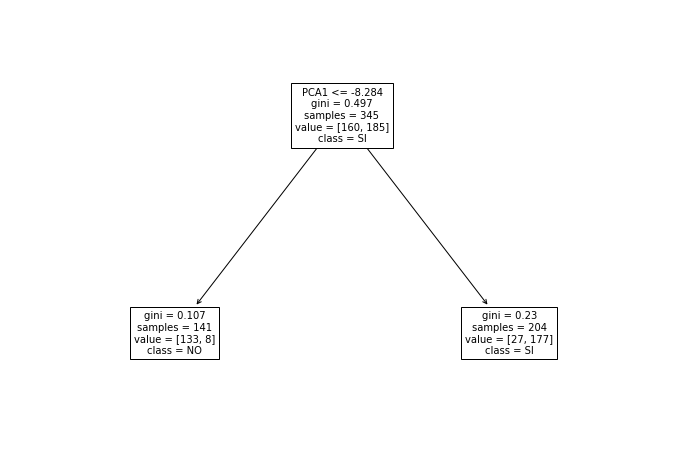

In [ ]:
decision_tree_model = ms.get_model_by_id('DecisionTreeClassifier')
plt.figure(figsize=(12,8))
lista = plot_tree(decision_tree_model,feature_names=['PCA1'],class_names=list(sorted(['SI','NO'])), fontsize=10)
plt.show()

# Punto 13